In [1]:
import hail as hl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
hl.init()

Running on Apache Spark version 2.4.4
SparkUI available at http://a783b4e25167:4042
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/organism/canine/hail-20200212-2155-0.2.30-2ae07d872f43.log


### MAF and Call Rates

In [131]:
mt = hl.balding_nichols_model(3, 6, 10)
mt = mt.annotate_entries(GT=hl.case().when(hl.rand_bool(.5, seed=1), mt.GT).or_missing())
mt = hl.variant_qc(mt)
mt.count()

2020-02-12 23:02:12 Hail: INFO: balding_nichols_model: generating genotypes for 3 populations, 6 samples, and 10 variants...


(10, 6)

In [132]:
mt.aggregate_entries(hl.agg.fraction(hl.is_defined(mt.GT)))

0.48333333333333334

In [133]:
m = hl.linalg.BlockMatrix.from_entry_expr(
    hl.case().when(hl.is_defined(mt.GT), mt.GT.n_alt_alleles()).default(-1)
).to_numpy()
pd.DataFrame(m, index=mt.locus.collect(), columns=mt.pop.collect())

2020-02-12 23:02:14 Hail: INFO: Coerced sorted dataset
2020-02-12 23:02:14 Hail: INFO: Wrote all 1 blocks of 10 x 6 matrix with block size 4096.


,2,1,2,2,0,0
1:1,1.0,-1.0,2.0,1.0,0.0,2.0
1:2,2.0,2.0,2.0,-1.0,2.0,-1.0
1:3,1.0,-1.0,-1.0,-1.0,2.0,2.0
1:4,-1.0,2.0,-1.0,-1.0,2.0,1.0
1:5,0.0,-1.0,1.0,-1.0,-1.0,-1.0
1:6,2.0,-1.0,1.0,-1.0,-1.0,-1.0
1:7,0.0,-1.0,-1.0,0.0,2.0,-1.0
1:8,2.0,2.0,-1.0,-1.0,2.0,2.0
1:9,-1.0,2.0,-1.0,1.0,-1.0,-1.0
1:10,-1.0,0.0,-1.0,-1.0,-1.0,-1.0


In [134]:
def get_maf(mt):
    mt = mt.annotate_rows(maf=hl.agg.group_by(
        mt.pop, hl.agg.sum(mt.GT.n_alt_alleles()) / (hl.agg.count_where(hl.is_defined(mt.GT)) * 2)))
    return mt

def get_cr(mt):
    mt = mt.annotate_rows(cr=hl.agg.group_by(
        mt.pop, hl.agg.fraction(hl.is_defined(mt.GT))))
    return mt

In [135]:
mt = get_maf(mt)
mt = get_cr(mt)

In [136]:
mt.maf.collect()

2020-02-12 23:02:15 Hail: INFO: Coerced sorted dataset


[{0: 0.5, 1: nan, 2: 0.6666666865348816},
 {0: 1.0, 1: 1.0, 2: 1.0},
 {0: 1.0, 1: nan, 2: 0.5},
 {0: 0.75, 1: 1.0, 2: nan},
 {0: nan, 1: nan, 2: 0.25},
 {0: nan, 1: nan, 2: 0.75},
 {0: 1.0, 1: nan, 2: 0.0},
 {0: 1.0, 1: 1.0, 2: 1.0},
 {0: nan, 1: 1.0, 2: 0.5},
 {0: nan, 1: 0.0, 2: nan}]

In [137]:
pd.Series(pd.DataFrame(mt.maf.collect()).values.ravel()).describe()

2020-02-12 23:02:16 Hail: INFO: Coerced sorted dataset


count    19.000000
mean      0.732456
std       0.348696
min       0.000000
25%       0.500000
50%       1.000000
75%       1.000000
max       1.000000
dtype: float64

In [138]:
mt.aggregate_entries(hl.agg.sum(hl.is_defined(mt.GT)))

29

In [141]:
len(pd.DataFrame(mt.GT.collect()).dropna())

2020-02-12 23:02:33 Hail: INFO: Coerced sorted dataset


29

## LD Prune

In [37]:
def get_mt():
    data = []
    n_var, n_samp = 1000, 100
    calls = [[0, 0], [0, 1], [1, 0], [1, 1]]
    np.random.seed(1)
    for i in range(n_var):
        for j in range(n_samp):
            contig = 1
            pos = i + 1
            v = '{}:{}:A:C'.format(contig, pos)
            call = hl.Call(calls[np.random.randint(0, len(calls))])
            data.append(dict(v=v, s='s' + str(j), GT=call))
    ht = hl.Table.parallelize(data, hl.dtype('struct{v: str, s: str, GT: call}'))
    ht = ht.transmute(**hl.parse_variant(ht.v))
    mt = ht.to_matrix_table(row_key=['locus', 'alleles'], col_key=['s'])
    return mt
mt = get_mt()

In [38]:
mt = mt.repartition(10)
mt.write('/tmp/sim.mt', overwrite=True)
mt = hl.read_matrix_table('/tmp/sim.mt')

2020-02-15 11:58:57 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-15 11:58:58 Hail: INFO: wrote matrix table with 1000 rows and 100 columns in 10 partitions to /tmp/sim.mt


In [39]:
bm = hl.linalg.BlockMatrix.from_entry_expr(mt.GT.n_alt_alleles())
bm.to_numpy()

2020-02-15 11:58:58 Hail: INFO: Wrote all 1 blocks of 1000 x 100 matrix with block size 4096.


array([[1., 2., 0., ..., 1., 0., 2.],
       [1., 1., 2., ..., 1., 1., 1.],
       [0., 1., 0., ..., 0., 0., 2.],
       ...,
       [1., 2., 0., ..., 0., 1., 1.],
       [2., 0., 2., ..., 0., 1., 2.],
       [1., 1., 1., ..., 0., 0., 1.]])

In [40]:
#bp_window = int(1e6)
bp_window = int(999)

In [41]:
def get_ld_window(mt, radius):
    bm = hl.ld_matrix(mt.GT.n_alt_alleles(), mt.locus, radius=radius)
    lw = hl.linalg.utils.locus_windows(mt.locus, radius=radius)
    bm = bm.sparsify_row_intervals(*lw)
    return bm

bm_ld = get_ld_window(mt, bp_window)
bm_ld.to_numpy()

2020-02-15 11:58:59 Hail: INFO: Wrote all 1 blocks of 1000 x 100 matrix with block size 4096.


array([[ 1.        , -0.03818714,  0.09869173, ...,  0.0428778 ,
        -0.07625871, -0.06317932],
       [-0.03818714,  1.        , -0.04703406, ..., -0.08088659,
         0.0028393 ,  0.1798219 ],
       [ 0.09869173, -0.04703406,  1.        , ..., -0.01496324,
        -0.17141454,  0.28878474],
       ...,
       [ 0.0428778 , -0.08088659, -0.01496324, ...,  1.        ,
         0.1462257 ,  0.00751293],
       [-0.07625871,  0.0028393 , -0.17141454, ...,  0.1462257 ,
         1.        , -0.07850084],
       [-0.06317932,  0.1798219 ,  0.28878474, ...,  0.00751293,
        -0.07850084,  1.        ]])

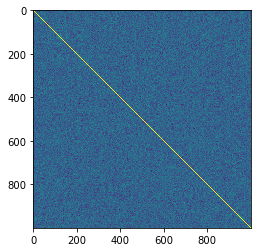

In [42]:
plt.imshow(bm_ld.to_numpy())

In [43]:
df = bm_ld.entries().to_pandas()

In [44]:
df.head()

,i,j,entry
0,0,0,1.000000
1,0,1,-0.038187
2,0,2,0.098692
3,0,3,-0.036765
4,0,4,-0.204822


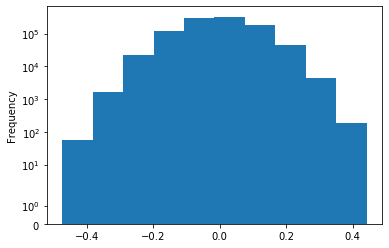

In [45]:
ax = df[df['i'] != df['j']]['entry'].plot(kind='hist', bins=32)
ax.set_yscale('symlog')

In [46]:
ht_pr = hl.ld_prune(mt.GT, r2=0.9, bp_window_size=bp_window)
mt_pr = mt.filter_rows(hl.is_defined(ht_pr[mt.row_key]))

2020-02-15 11:59:10 Hail: INFO: ld_prune: running local pruning stage with max queue size of 894785 variants
2020-02-15 11:59:10 Hail: INFO: wrote table with 1000 rows in 10 partitions to file:/tmp/hail.LCVhzO4Qzu0j/WlMpkh1E68
2020-02-15 11:59:11 Hail: INFO: Wrote all 1 blocks of 1000 x 100 matrix with block size 4096.
2020-02-15 11:59:12 Hail: INFO: wrote table with 0 rows in 1 partition to file:/tmp/hail.LCVhzO4Qzu0j/5YB4NZhP3z


In [47]:
mt_pr.count()

(1000, 100)

In [20]:
bm_ld = get_ld_window(mt_pr, bp_window)
bm_ld.to_numpy()

2020-02-15 11:16:57 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-15 11:16:57 Hail: INFO: Wrote all 1 blocks of 3 x 4 matrix with block size 4096.
2020-02-15 11:16:57 Hail: INFO: Ordering unsorted dataset with network shuffle
2020-02-15 11:16:58 Hail: INFO: Ordering unsorted dataset with network shuffle


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])